<a href="https://colab.research.google.com/github/mintusf/CIFAR/blob/master/Semi-supervised%20training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-unsupervised CIFAR-10 classification

---


**Data downloading and pre-processing**

This script present model for classification of undersampled CIFAR-10 dataset. All functions needed to build and and train model are included.

At first, let's connect with google drive in order to download dataset data.
You need to click the shown link, choose your google account and allow Google Cloud SDK to access it. The password will be shown which should be inputed in blank area.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Now, let's download data from Google Drive.



*   Train -> undersampled dataset with 42500 examples
*   Train_augmented -> training dataset where some augmented examples were added to undersampled classes (50000 examples in total)
*   Dev -> balanced dataset with 5000 examples for model development (cross validation)
*   Test -> balanced dataset with 5000 examples for final model check

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Downloading Train_X file containing 42500 examples with undersampled classes [bird, deer, truck]
link = 'https://drive.google.com/open?id=1MfxFllrpEduRC6L42cthQwNWtdtE6DiG'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Train_X')

# Downloading Train_Y file containing 42500 labels for Train_X
link = 'https://drive.google.com/open?id=1_WtueFsji8R9o6QFVHfoYfphnYykHQqG'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Train_Y')

# Downloading Train_X_augmented file containing 50000 examples with 7500 examples being augmented images of undersampled classes [bird, deer, truck]
link = 'https://drive.google.com/open?id=1Vnfgpdwg248OI91BwoWlUG7rAW8ewYCK'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Train_X_augmented')

# Downloading Train_Y file containing 50000 labels for Train_X_augmented
link = 'https://drive.google.com/open?id=1bCrf0yc_Axh0RKkpbHCdNislxvdJZ9VO'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Train_Y_augmented')

link = 'https://drive.google.com/open?id=1X_vSxFLO-IBmPGZ8mP9tK9jtyrkf27dl'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Dev_X')

link = 'https://drive.google.com/open?id=1bEJFQb6rSWnEREG3IBIxvN3enYt0jT0X'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Dev_Y')

link = 'https://drive.google.com/open?id=1v1t_Gu4Ulyt58mSg_bwIeJbvJq0OA80l'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Test_X')

link = 'https://drive.google.com/open?id=1BV8IxrBW46H0Jj_NatVsORQmAki3Osdt'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Test_Y')

Let's download needed libraries

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In the next step, downloaded files will be loaded into variables into dataset variables. Input images are normalized to the range <0, 1> in order to improve training.

In [0]:
X_train = np.load('Train_X')/255.
Y_train_1d = np.load('Train_Y')
X_dev = np.load('Dev_X')/255.
Y_dev_1d = np.load('Dev_Y')
X_test = np.load('Test_X')/255.
Y_test_1d = np.load('Test_Y')
X_train_augmented = np.load('Train_X_augmented')/255.
Y_train_augmented_1d = np.load('Train_Y_augmented')


Next step is to convert labels into one-hot format. The reason of that is that softmax activation will be used in the last layer which outputs vector with the lenght of the number of classes containing probabilities for each class.

In [15]:
Y_train = np.eye(10)[Y_train_1d.reshape(-1)]
print(Y_train.shape)
Y_dev = np.eye(10)[Y_dev_1d.reshape(-1)]
print(Y_dev.shape)
Y_test = np.eye(10)[Y_test_1d.reshape(-1)]
print(Y_test.shape)
Y_train_augmented = np.eye(10)[Y_train_augmented_1d.reshape(-1)]
print(Y_train_augmented.shape)

(42500, 10)
(5000, 10)
(5000, 10)
(50000, 10)


Let's save names of labels.

In [0]:
names = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

**Autoencoder development**

Keras framework will be used for building the model.It includes many functions which simplifies creating deep learning algorithms.

In [0]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout,UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Now, let's build the model of convolutional autoencoder. 

---


Autoencoders use same examples as inputs and outputs in order to remove data which are unrelevant for classification and extract informational features in hidden layers which can be used for classification. Usually hidden layers have smaller shape than input in order to 'force' the algorithm to find most useful features. An autoencoder can be divided into encoder and decoder. While the first one encodes the image into lower-dimension format, the second decodes it into the same format as input. Usually, a decoder has a symetrical architecture of an encoder.

The architecture is based on VGG-16. It consists of blocks CONV->BN->DROPOUT, however it is important that when MaxPooling layer is used to decrease dimensions, dropout should not be used before it but after. For the training, data augmentation is used.

Following function creates a CNN model of autoencoder connecting input layer with output layer.
  

> Arguments:
*   input_img -> an input layer consisting image
*   dropout -> probability of dropout



> Returns:
*   encoded -> a tensor of hidden layer which is used as encoder of input image
*   decoded -> the output of autoencoder









In [0]:
def Autoencoder (input_img,dropout):

    # The Autoencoder is divided into encoder and decoder
    # Shape of input is 32,32,3

    # First convolution block of encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Conv1_encoder')(input_img)  # Shape: 32x32x64
    x = BatchNormalization(name = 'BN0')(x)
    x = Dropout(dropout)(x)

    # Second convolution block of encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Conv2_encoder')(x) # Shape: 32x32x64
    x = BatchNormalization(name = 'BN1')(x)
    
    # Max Pooling for dimensions reduction
    x = MaxPooling2D((2,2),name = 'MP1')(x)# 16x16x64
    x = Dropout(dropout)(x)

    # Third convolution block of encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name = 'Conv3_encoder')(x) # Shape: 16x16x128
    x = BatchNormalization(name = 'BN2')(x)
    x = Dropout(dropout)(x)

    # Fourth convolution block of encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name = 'Conv4_encoder')(x) # Shape: 16x16x128
    x = BatchNormalization(name = 'BN3')(x)
    
    # Max Pooling for dimensions reduction
    x = MaxPooling2D((2, 2), padding='same',name = 'MP2')(x) # Shape: 8x8x128
    x = Dropout(dropout)(x)

    # Fifth convolution block of encoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name = 'Conv5_encoder')(x) # Shape: 8x8x256
    x = BatchNormalization(name = 'BN4')(x)
    x = Dropout(dropout)(x)

    # Sixth convolution block of encoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name = 'Conv6_encoder')(x) # Shape: 8x8x256
    x = BatchNormalization(name = 'Encoded')(x)

    # the encoded representation's shape is 8x8x256
    encoded = x

    # First convolution block of decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name = 'Conv6_decoder')(encoded) # Shape: 8x8x256
    x = BatchNormalization(name = 'BN6')(x)
    x = Dropout(dropout)(x)

    # Second convolution block of decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name = 'Conv5_decoder')(x) # Shape: 8x8x256
    x = BatchNormalization(name = 'BN7')(x)
    
    x = UpSampling2D((2,2),name = 'US1')(x) # Shape: 16x16x256
    x = Dropout(dropout)(x)

    # Third convolution block of decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name = 'Conv4_decoder')(x) # Shape: 16x16x128
    x = BatchNormalization(name = 'BN8')(x)
    x = Dropout(dropout)(x)

    # Fourth convolution block of decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name = 'Conv3_decoder')(x) # Shape: 16x16x128
    x = BatchNormalization(name = 'BN9')(x)
    
    x = UpSampling2D((2,2),name = 'US2')(x) # Shape: 32x32x128
    x = Dropout(dropout)(x)
    
    # Fifth convolution block of decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Conv2_decoder')(x) # Shape: 32x32x64
    x = BatchNormalization(name = 'BN10')(x)
    x = Dropout(dropout)(x)

    # Sixth convolution block of decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Conv1_decoder')(x) # Shape: 32x32x64
    x = BatchNormalization(name = 'BN11')(x)
    x = Dropout(dropout)(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name = 'Output')(x) # Shape: 32x32x3

    return (encoded, decoded)

Following function creates autoencoder network.

> Arguments:
*   dropout -> probability of dropout
*   load_weights -> boolean argument deciding if weights of a pre-trained model should be used as initial
*   train -> boolean argument deciding if the model should be train (it is possible to just load weights without training)
*   save_model -> boolean deciding if model and its weigths be save on google drive
*   augmentation -> boolean deciding if augmentation is used
*   model_name -> string with the name of file with weigths to be saved




> Returns:
*   model_autoenc -> a class of created model
*   history -> a history of training process (if trained)


In [0]:
def autoencoder_train(x_train, x_dev,dropout,load_weights = False, train_model = True, save_model = False, augmentation = False, model_name=''):
  # Creating the tensor of input layer
  input_img = Input(shape = (32,32,3))

  # Creating a model based on architecture from Autoencoder function
  model_autoenc = Model(input_img,Autoencoder(input_img,dropout)[1],name = 'Autoencoder')

  # Defining Adam as used optimizer
  Adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  # Compiling the model with mean square error as loss function, because it will represent how much information is lost by average in each pixel  
  model_autoenc.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  # Printing model's architecture
  model_autoenc.summary()

  # Loading weights from google drive file
  if load_weights:
    last_weight_file = drive.CreateFile({'id': '1uQ4fMOlGQeXj-Wh7az6bixJcFJAymez0'}) 
    last_weight_file.GetContentFile('last_weights.mat')
    model_autoenc.load_weights('last_weights.mat')
    print('Weights loaded.')

  # Autoencoder training
  if train_model:
  
  # Creating data generator 
    if augmentation:
      datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
      
      # Fitting data generator to training dataset
      datagen.fit(x_train)

      # Training
      history = model_autoenc.fit_generator(datagen.flow(x_train, x_train,
                                      batch_size=256),
                          steps_per_epoch=x_train.shape[0] // batch_size,
                          epochs=50,
                          validation_data=(x_dev, x_dev),verbose=2)
    
    # Training without augmentation option
    else:
        history = model_autoenc.fit(x_train, x_train, validation_data=(x_dev, x_dev), epochs = 50, batch_size = 256,verbose = 2)
    print('Training finished.')
  else:
    history = None
  if save_model:
    # Saving model on Google Drive
    model_autoenc.save(model_name + '.h5')    
    model_file = drive.CreateFile({'title' : model_name + '.h5'})
    model_file.SetContentFile(model_name + '.h5')
    model_file.Upload()
    drive.CreateFile({'id': model_file.get('id')})
    print(f"Model saved, id: {model_file.get('''id''')}")

    # Saving weights on Google Drive
    model_autoenc.save_weights(model_name + '_weights.h5')
    weights_file = drive.CreateFile({'title' : model_name + '_weights.h5'})
    weights_file.SetContentFile(model_name + '_weights.h5')
    weights_file.Upload()
    drive.CreateFile({'id': weights_file.get('id')})
    print(f"Weights saved, id: {model_file.get('''id''')}")

  return model_autoenc, history

Now autoencoder model can be created. By default, weights from a pre-trained mode are used.

Note:
If download error is raised, please rerun first cell from the script.

In [24]:
model_autoenc, history = autoencoder_train(X_train_augmented, X_dev, 0.1,load_weights = True, train_model = False,save_model=False,augmentation = False)

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Conv1_encoder (Conv2D)       (None, 32, 32, 64)        1792      
_________________________________________________________________
BN0 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2_encoder (Conv2D)       (None, 32, 32, 64)        36928     
_________________________________________________________________
BN1 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
MP1 (MaxPooling2D)           (None, 16, 16, 64)        

Following function visualize training process.

In [0]:
def visualize_training(history):
  import matplotlib.pyplot as plt

  figure,ax = plt.subplots(1,2,figsize = (10,4))
  ax[0].plot(history.history['acc'])
  ax[0].plot(history.history['val_acc'])
  ax[0].set_title('Model accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Test'], loc='upper left')

  # Plot training & validation loss values
  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [0]:
if history!=None:
  visualize_training(history)

Let's see the example of input image and decoded output from autoencoder.

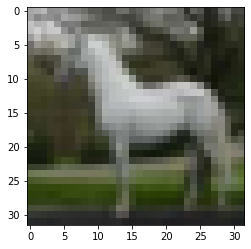

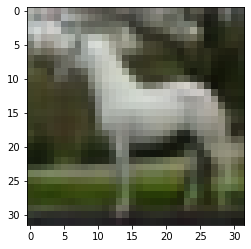

In [27]:
import matplotlib.pyplot as plt

i = np.random.randint(5000)
decoded = model_autoenc.predict(np.reshape(X_test[i],(-1,32,32,3)))
plt.imshow(X_test[i])
plt.show()
plt.imshow(decoded[0])

It seems that not much information is lost. It means that the autoencoder does not decrease variance of image.

**Classifier development**

Now let's create another network for final classification, which will be 'attached' to the hidden layer inside of the developed autoencoder called. The goal is to use features extracted by autoencoder as input to classification network in order to achieve accurate classification.

Following function build the classification model consisting of 2 convolutional blocks (Conv, Batch_norm, Activation and dropout) using autoencoder's hidden layer as input.

> Arguments:
*   encoded -> tensor of input layer for the network
*   weights_decay -> l2 regularization parameter
*   train -> boolean argument deciding if the model should be train (it is possible to just load weights without training)
*   num_classes -> number of classes
*   dropout -> the probability of dropout 



> Returns:
*   X -> tensor with output layer of classifier (shape [m,10])

In [0]:
def build_model(encoded,weight_decay,num_classes,dropout,dropout_fc):

      # First convolutional block
      X = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(encoded)
      X = BatchNormalization()(X)
      X = Activation('relu')(X)
      
      X = MaxPooling2D(pool_size=(2, 2))(X)
      X = Dropout(dropout)(X)

      # First convolutional block
      X = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(X)
      X = BatchNormalization()(X)
      X = Activation('relu')(X)  
      
      X = MaxPooling2D(pool_size=(2, 2))(X)
      X = Dropout(dropout)(X)

      # First fully connected layer
      X = Flatten()(X)
      X = Dense(1024,kernel_regularizer=regularizers.l2(weight_decay))(X)
      X = BatchNormalization()(X)
      X = Activation('relu')(X)  
      X = Dropout(dropout_fc)(X)

      # Second fully connected layer
      X = Dense(1024,kernel_regularizer=regularizers.l2(weight_decay))(X)
      X = BatchNormalization()(X)
      X = Activation('relu')(X)  
      X = Dropout(dropout_fc)(X)

      # Output layer with softmax function
      X = Dense(num_classes)(X)
      X = Activation('softmax')(X)
      
      return X

Nextr function is for training the classifier

> Arguments:
*   epochs -> number of epochs for training
*   model_classifier -> instance of a model to be trained
*   x_train -> training dataset
*   y_train -> training labels
*   x_dev -> development dataset
*   y_dev -> development labels
*   learning rate
*   augmentation -> boolean deciding if augmentation is used



> Returns:
*   model_classifier -> trained model
*   history -> training history

In [0]:
def train(epochs,model_classifier,x_train,y_train,x_dev,y_dev,learning_rate=0.001, augmentation = True):

    #training parameters
    batch_size = 128

    #data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    # Fitting generator to training dataset
    datagen.fit(x_train)

    # class weights for loss function
    class_weight = {0: 1.,1: 1.,2: 5.,3: 2.,4: 3.,5: 4.,6: 1.,7: 1.,8: 1.,9: 1.}

    # Training with augmentation
    if augmentation:
      history = model_classifier.fit_generator(datagen.flow(x_train, y_train,
                                      batch_size=batch_size),
                          steps_per_epoch=x_train.shape[0] // batch_size,
                          epochs=epochs,
                          validation_data=(x_dev, y_dev),verbose=2,class_weight = class_weight)
    
    else:  
      history = model_classifier.fit(x_train,y_train, batch_size=batch_size,epochs=maxepoches,validation_data=(x_test, y_test),verbose=1,class_weight = class_weight)

    return model_classifier, history

Nextr function is for training the classifier

> Arguments:
*   epochs -> number of epochs for training
*   x_train -> training dataset
*   y_train -> training labels
*   x_dev -> development dataset
*   y_dev -> development labels
*   load_weights -> boolean deciding if pre-trained weigths should be downloaded
*   train_model -> boolean deciding if training process is executed
*   trainable_autoencoder -> boolean deciding if autoencoder layers are trainable
*   save_weights -> boolean deciding if optimized weights are saved on google drive
*   augmentation -> boolean deciding if augmentation is used
*   learning rate
*   dropout -> probability for classifier's CNN layers
*   dropout_fc -> probability for fully connected layers
*   weights_id -> google drive id of weights to be loaded
*   model_name -> name of model for saved files


> Returns:
*   model -> trained model
*   history -> training history

In [0]:
from tensorflow.keras import optimizers

def build_and_train(epochs,x_train,y_train,x_dev,y_dev,load_weights=True,train_model=True,trainable_autoencoder=True, save_weights = False, augmentation = True,learning_rate=0.001, dropout = 0.1, weights_id = None,ae_drop = 0.0, dropout_fc=0.3,model_name=''):
  
    # Model parameters
    num_classes = 10
    weight_decay = 0
    x_shape = [32,32,3]
    input_img = Input((32,32,3))

    # Creating instance of encoder's part of autoencoder model
    encoded = Autoencoder(input_img,ae_drop)[0]

    # Joining classifier with encoder
    model = Model(input_img,build_model(encoded,weight_decay,num_classes,dropout,dropout_fc=dropout_fc))

    # Copying weights from encoder
    for l1,l2 in zip(model.layers[:20],model_autoenc.layers[:20]):
      l1.set_weights(l2.get_weights())

    # Choosing trainability of encoder's layers
    for layer in model.layers[0:20]:
      layer.trainable = trainable_autoencoder

    # Loading weights of a whole classifier (if set)
    if load_weights:
      last_weight_file = drive.CreateFile({'id': weights_id}) 
      last_weight_file.GetContentFile('last_weights.mat')
      model.load_weights('last_weights.mat')

    # Printing model's structure
    model.summary()

    # Using Adam optimizer
    adam = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

    # Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])

    # Training the model
    if train_model:
      model,history = train(epochs, model,x_train,y_train,x_dev,y_dev,learning_rate,augmentation)
    else:
      history=None

    if save_weights:
      # saving model
      model.save(model_name + '.h5')    
      model_file = drive.CreateFile({'title' : model_name + '.h5'})
      model_file.SetContentFile(model_name + '.h5')
      model_file.Upload()
      drive.CreateFile({'id': model_file.get('id')})
      print(f"Model saved, id: {model_file.get('''id''')}")

      # saving weights
      model.save_weights(model_name + '_weights.h5')
      weights_file = drive.CreateFile({'title' : model_name + '_weights.h5'})
      weights_file.SetContentFile(model_name + '_weights.h5')
      weights_file.Upload()
      drive.CreateFile({'id': weights_file.get('id')})
      print(f"Weights saved, id: {model_file.get('''id''')}")

    return model,history


Let's use these functions to train model.

In [36]:
with tf.device('/device:GPU:0'):
  model_classifier1,history = build_and_train(100,X_train_augmented,Y_train_augmented,X_dev,Y_dev,load_weights=False, train_model=True,trainable_autoencoder=True, save_weights = False,dropout = 0.4, ae_drop = 0.4, dropout_fc=0.4,weights_id = '1YFjoNan-Uyir-9ul6CBbGNN2QnAJik6t')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Conv1_encoder (Conv2D)       (None, 32, 32, 64)        1792      
_________________________________________________________________
BN0 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_48 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2_encoder (Conv2D)       (None, 32, 32, 64)        36928     
_________________________________________________________________
BN1 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
MP1 (MaxPooling2D)           (None, 16, 16, 64)        0   

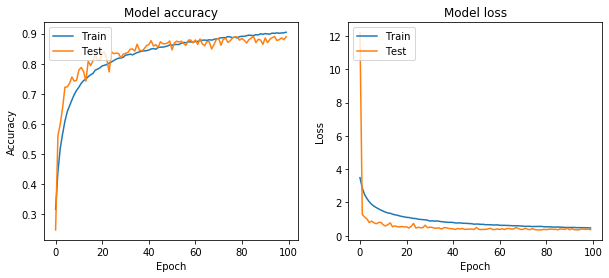

In [37]:
if history!=None:
  visualize_training(history)

Let's download pre-trained weights with the best performance.

Note:
If download error is raised, please rerun first cell from the script.

In [43]:
with tf.device('/device:GPU:0'):
  model_classifier1,history = build_and_train(100,X_train_augmented,Y_train_augmented,X_dev,Y_dev,load_weights=True, train_model=False,trainable_autoencoder=True, save_weights = False,dropout = 0.4, ae_drop = 0.4, dropout_fc=0.4,weights_id = '1YFjoNan-Uyir-9ul6CBbGNN2QnAJik6t')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Conv1_encoder (Conv2D)       (None, 32, 32, 64)        1792      
_________________________________________________________________
BN0 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_93 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2_encoder (Conv2D)       (None, 32, 32, 64)        36928     
_________________________________________________________________
BN1 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
MP1 (MaxPooling2D)           (None, 16, 16, 64)        0   

Next cell shows model's evaluation, mislabeled examples and classes misclassification distribution.

5000/5000 [==============================] - 6s 1ms/sample - loss: 0.3783 - acc: 0.8954
(5000,)
(5000,)
[ True False  True ...  True  True  True]
(482, 32, 32, 3)


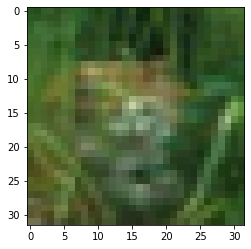

Class: cat
Predicted: frog


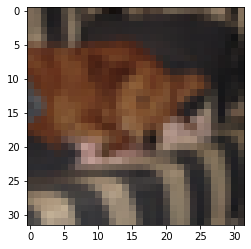

Class: dog
Predicted: cat


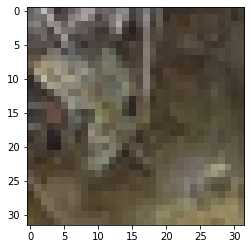

Class: frog
Predicted: deer


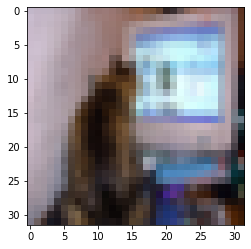

Class: cat
Predicted: truck


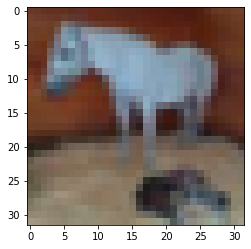

Class: horse
Predicted: cat
The number of mistaken airplanes is: 29
The number of mistaken automobiles is: 9
The number of mistaken birds is: 72
The number of mistaken cats is: 101
The number of mistaken deers is: 101
The number of mistaken dogs is: 51
The number of mistaken frogs is: 27
The number of mistaken horses is: 30
The number of mistaken ships is: 23
The number of mistaken trucks is: 39


In [44]:
import tensorflow.keras.backend as K
model_classifier1.evaluate(X_test,Y_test)
predictions = np.argmax(model_classifier1.predict(X_dev),axis = 1)
labels = np.argmax(Y_dev,axis = 1)
print(predictions.shape)
print(labels.shape)
print(np.equal(predictions,labels))
mistaken = X_dev[np.not_equal(predictions,labels)]
new_labels = labels[np.not_equal(predictions,labels)]
new_predictions = predictions [np.not_equal(predictions,labels)]
print(mistaken.shape)

for i in range(5):
  plt.imshow(mistaken[i,:,:,:])
  plt.show()
  print("Class: "+names[new_labels[i]])
  print("Predicted: "+names[new_predictions[i]])

for i in range(10):
  count = np.sum(new_labels==i)
  print("The number of mistaken "+ names[i] + "s is: "+ str(count))

Classification report and confusion matrix are another ways to evaluate a model:

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(labels,predictions))
print(confusion_matrix(labels,predictions))
print(names)
print(X_test.shape)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       484
           1       0.94      0.98      0.96       496
           2       0.90      0.85      0.87       478
           3       0.85      0.81      0.83       527
           4       0.94      0.80      0.87       509
           5       0.83      0.90      0.86       519
           6       0.89      0.95      0.92       518
           7       0.93      0.94      0.94       477
           8       0.94      0.95      0.95       486
           9       0.95      0.92      0.94       506

    accuracy                           0.90      5000
   macro avg       0.91      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

[[455   2   6   3   2   1   1   0  12   2]
 [  1 487   0   0   0   0   1   0   1   6]
 [ 12   0 406  14   6  13  15   5   2   5]
 [  9   2   9 426   6  51  15   3   3   3]
 [  5   1  18  14 408  19  25  15   4   0]
 [  3   0   4  25   3 468 